<a href="https://colab.research.google.com/github/ftkbyond77/Deeplearning_CNN1/blob/main/FashioMNIST1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FashionMNIST

## Pre-Training Phase

### 1. Visualize Metadata

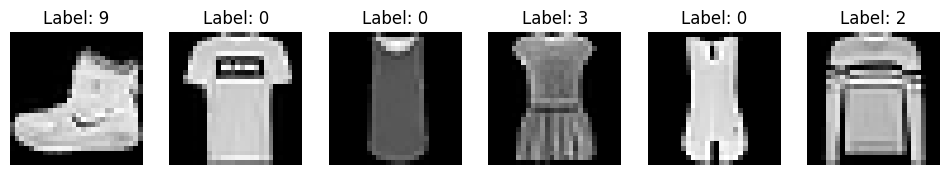

In [22]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn

transform = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

fig, axes = plt.subplots(1, 6, figsize=(12, 4))
for i in range(6):
  image, label = trainset[i]
  axes[i].imshow(image.squeeze(), cmap='gray')
  axes[i].set_title(f'Label: {label}')
  axes[i].axis(False)
plt.show()

In [8]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
class_idx = trainset.class_to_idx
class_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 2. Data Augmentation & Transform


In [13]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

### 3. Distribution

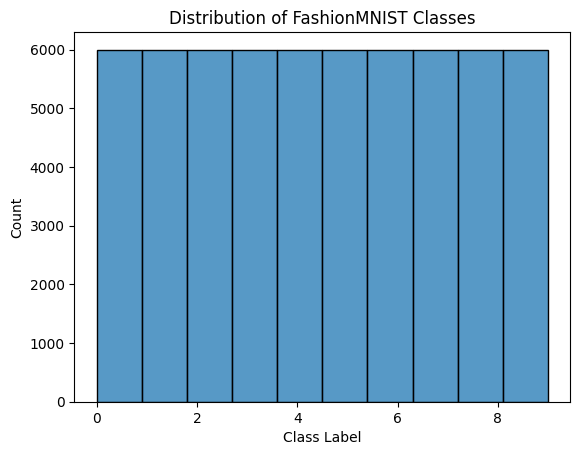

In [17]:
import seaborn as sns
import numpy as np

labels = np.array([label for _, label in trainset])
sns.histplot(labels, bins=10, kde=False)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of FashionMNIST Classes")
plt.show()

## Training Phase

`CNN Model`

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
model = CNN()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

# Save Model
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")


Epoch [1/5], Loss: 0.5004
Epoch [2/5], Loss: 0.3360
Epoch [3/5], Loss: 0.2898
Epoch [4/5], Loss: 0.2616
Epoch [5/5], Loss: 0.2448


## Post-Training Phase

### Apply new dataset (modified FashionMNIST)

In [28]:
import random

def add_noise(image, noise_factor=0.5):
  noise = torch.randn_like(image) * noise_factor
  return torch.clamp(image + noise, 0., 1.)

# Test data with Noise
testset_noise = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_noise(x, 0.3)),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

testloader_noise = DataLoader(testset_noise, batch_size=64, shuffle=False)

In [31]:
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in testloader_noise:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on Noisy Dataset: {100 * correct / total:.2f}%")

Accuracy on Noisy Dataset: 45.45%


### Fine-Tune

In [32]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in testloader_noise:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Fine-Tuning Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(testloader_noise):.4f}")

Fine-Tuning Epoch [1/2], Loss: 0.6160
Fine-Tuning Epoch [2/2], Loss: 0.4580


## Visualizing Model Predictions

In [36]:
# Mapping Label ID → Class Name
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def visualize_predictions(model, dataloader, device):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 6, figsize=(12, 5))
    fig.suptitle("Model Predictions", fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i >= len(images): break

        img = images[i].cpu().squeeze()
        label = labels[i].item()
        pred = predictions[i].item()

        # ตั้งสี Title
        color = 'green' if pred == label else 'red'
        ax.set_title(f"{class_names[pred]}", color=color)

        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.show()

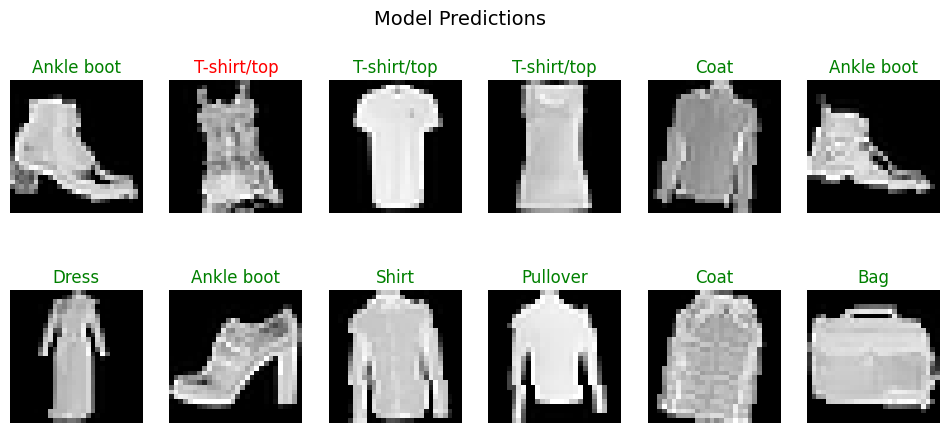

In [35]:
# Visualize with trainset
visualize_predictions(model, trainloader, device)

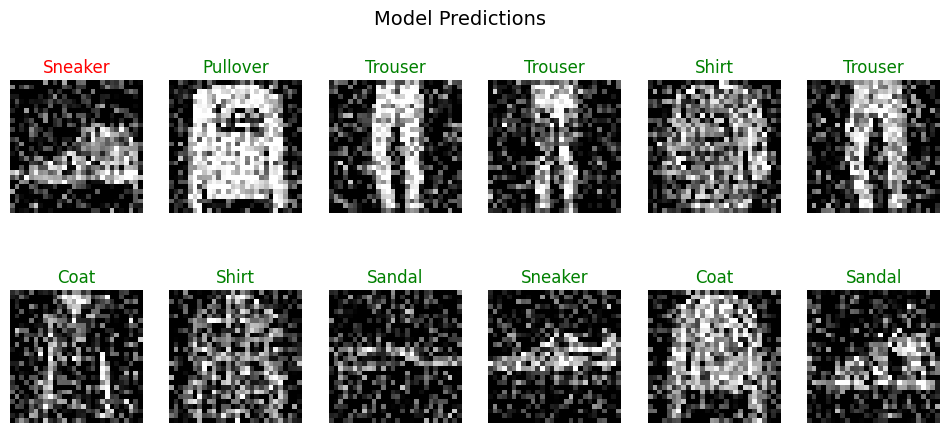

In [37]:
# Visualize with testset
visualize_predictions(model, testloader_noise, device)

## Grad-CAM checking (Gradient-weighted Class Activation Mapping)

using **gradient** of Conv for checking which parts was the most predicted

In [38]:
import torch.nn.functional as F

# Grad-CAM Function
def compute_gradcam(model, image, label, target_layer):
    model.eval()

    # เปิดใช้ Gradient
    image.requires_grad = True

    # Hook เพื่อดึง Feature Map และ Gradient
    activation = None
    gradient = None

    def forward_hook(module, input, output):
        nonlocal activation
        activation = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradient
        gradient = grad_output[0]

    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image.unsqueeze(0))
    loss = F.cross_entropy(output, torch.tensor([label]).to(device))

    # Backward pass
    model.zero_grad()
    loss.backward()

    # ลบ Hook
    hook_fwd.remove()
    hook_bwd.remove()

    # Compute Grad-CAM
    weights = gradient.mean(dim=(2, 3), keepdim=True)
    gradcam = (weights * activation).sum(dim=1, keepdim=True)
    gradcam = F.relu(gradcam)

    # Normalize Grad-CAM
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()
    return gradcam.squeeze().detach().cpu().numpy()



In [41]:
import cv2

# แสดงผล Grad-CAM
def show_gradcam(model, dataloader, device, target_layer, num_images=6):
    model.to(device)
    model.eval()

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    fig, axes = plt.subplots(2, num_images, figsize=(12, 5))

    for i in range(num_images):
        img = images[i].cpu().squeeze().numpy()
        label = labels[i].item()

        # คำนวณ Grad-CAM
        gradcam = compute_gradcam(model, images[i], label, target_layer)

        # Resize Grad-CAM ให้ขนาดเท่ากับภาพเดิม
        gradcam_resized = cv2.resize(gradcam, (img.shape[1], img.shape[0]))

        # ซ้อน Grad-CAM บนภาพเดิม (ใช้ colormap JET)
        heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Normalize ภาพให้เป็น 0-255
        img_rgb = np.uint8(255 * (img - img.min()) / (img.max() - img.min()))
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)

        # ผสมภาพเดิม + Heatmap
        overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        # Plot 1: ภาพต้นฉบับ
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')

        # Plot 2: Grad-CAM
        axes[1, i].imshow(overlay)
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Grad-CAM", fontsize=12)
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


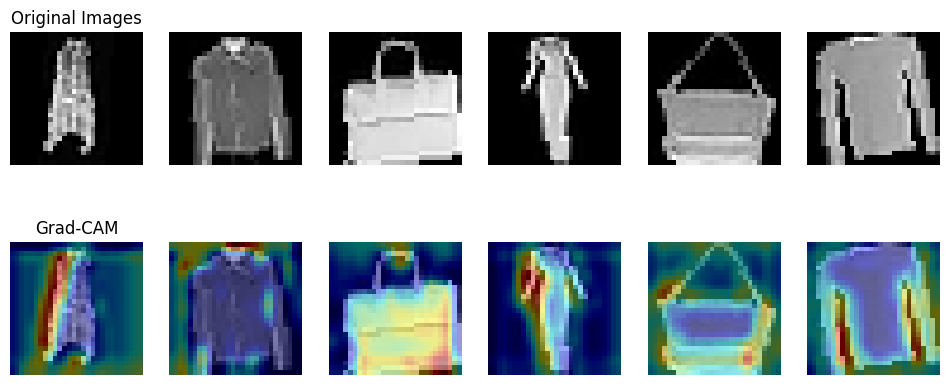

In [42]:
# using grad-cam on the first layer Conv (trainset)
show_gradcam(model, trainloader, device, model.conv2)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


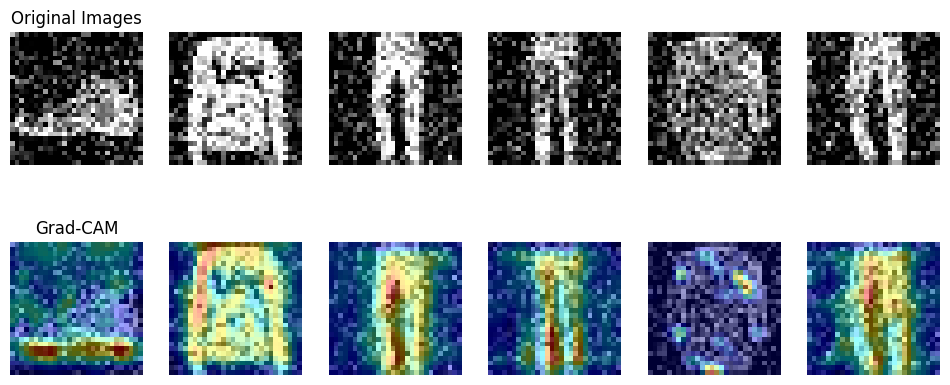

In [44]:
# using grad-cam on the first layer Conv (testset)
show_gradcam(model, testloader_noise, device, model.conv2)